# Movielens 영화 SBR
Movielens 1M Dataset을 기반으로, Session based Recommendation 시스템 제작

- 여기서 이전 실습 내역과 가장 크게 다른 부분은 바로 SessionID 대신 UserID 항목이 들어갔다는 점이다. 
    - 이 데이터셋은 명확한 1회 세션의 SessionID를 포함하지 않고 있다. 
    - 그래서 이번에는 UserID가 SessionID 역할을 해야 한다.

- Rating 정보가 포함되어 있다. 
    - 이전 실습 내역에서는 이런 항목이 포함되어 있지 않았으므로, 무시하고 제외할 수 있다. 
    - 하지만, 직전에 봤던 영화가 맘에 들었는지가 비슷한 영화를 더 고르게 하는 것과 상관이 있을 수도 있다. 
    - 아울러, Rating이 낮은 데이터를 어떻게 처리할지도 고민해야한다.

- Time 항목에는 UTC time 가 포함되어, 1970년 1월 1일부터 경과된 초 단위 시간이 기재되어 있다.




평가문항
1. Movielens 데이터셋을 session based recommendation 관점으로 전처리하는 과정이 체계적으로 진행되었다.	
    - 데이터셋의 면밀한 분석을 토대로 세션단위 정의 과정(길이분석, 시간분석)을 합리적으로 수행한 과정이 기술되었다.
2. RNN 기반의 예측 모델이 정상적으로 구성되어 안정적으로 훈련이 진행되었다.	
    - 적절한 epoch만큼의 학습이 진행되는 과정에서 train loss가 안정적으로 감소하고, validation 단계에서의 Recall, MRR이 개선되는 것이 확인된다.
3. 세션정의, 모델구조, 하이퍼파라미터 등을 변경해서 실험하여 Recall, MRR 등의 변화추이를 관찰하였다.
    - 3가지 이상의 변화를 시도하고 그 실험결과를 체계적으로 분석하였다.


In [1]:
import datetime as dt
from pathlib import Path
import os
import time
from datetime import datetime
from IPython.display import display

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

## Data Load

- UserId: 사용자 ID
- ItemId: 아이템(영화) ID
- Rating: 사용자가 해당 아이템에 부여한 평점
- Time: 평점이 기록된 시간 (1970년 1월 1일부터 경과된 초 단위)

In [2]:
print(os.getcwd())

/aiffel/aiffel/yoochoose


In [3]:
train_path = '/aiffel/aiffel/yoochoose/ratings.dat'

def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    return data

data = load_data(train_path, None)
data.sort_values(['UserId', 'Time'], inplace=True)  # data를 id와 시간 순서로 정렬해준다.
data

,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


### 데이터 기본 통계 정보 확인

In [4]:
data_info = {
    "Number of records": data.shape[0],
    "Number of users": data['UserId'].nunique(),
    "Number of items": data['ItemId'].nunique(),
    "Min rating": data['Rating'].min(),
    "Max rating": data['Rating'].max(),
    "Time range": pd.to_datetime(data['Time'], unit='s').agg(['min', 'max']).to_dict()
}

data_info

{'Number of records': 1000209,
 'Number of users': 6040,
 'Number of items': 3706,
 'Min rating': 1,
 'Max rating': 5,
 'Time range': {'min': Timestamp('2000-04-25 23:05:32'),
  'max': Timestamp('2003-02-28 17:49:50')}}

#### 유저 수와 아이템 수

In [5]:
user_counts = data['UserId'].nunique()
item_counts = data['ItemId'].nunique()

print(f'User Counts : {user_counts}')
print(f'Item Counts : {item_counts}')

User Counts : 6040
Item Counts : 3706


#### 평점 분포

In [6]:
rating_distribution = data['Rating'].value_counts().sort_index()
rating_distribution

1     56174
2    107557
3    261197
4    348971
5    226310
Name: Rating, dtype: int64

## Data Preprocess
간단히 구성해 본 데이터셋을 꼼꼼히 살펴보면서 항목별 기본 분석, session length, session time, cleaning 등의 작업을 진행힌다.  
특히, 이 데이터셋에서는 Session이 아닌 UserID 단위로 데이터가 생성되어 있으므로, 이를 Session 단위로 어떻게 해석할지에 주의한다.

### Session Length

#### 세션 길이 분석

In [7]:
session_lengths = data.groupby('UserId').size()
session_lengths.describe()

count    6040.000000
mean      165.597517
std       192.747029
min        20.000000
25%        44.000000
50%        96.000000
75%       208.000000
max      2314.000000
dtype: float64

##### 사용자별 세션 길이 분석
평균적으로 각 사용자는 약 166개의 영화 평가를 남겼다.  
사용자별 평가한 영화 수의 표준편차는 약 193으로, 사용자 간에 평가한 영화 수에 큰 차이가 있음을 보여준다.  
최소 평가 영화 수는 20개이고, 최대 평가 영화 수는 2314개이다.  
25%의 사용자는 44개 이하, 중앙값은 96개, 75%의 사용자는 208개 이하의 영화를 평가했다.  

#### 세션 길이 분포 확인

In [8]:
session_lengths.quantile([0.25, 0.5, 0.75, 0.9, 0.95, 0.99])

0.25     44.00
0.50     96.00
0.75    208.00
0.90    400.00
0.95    556.00
0.99    906.66
dtype: float64

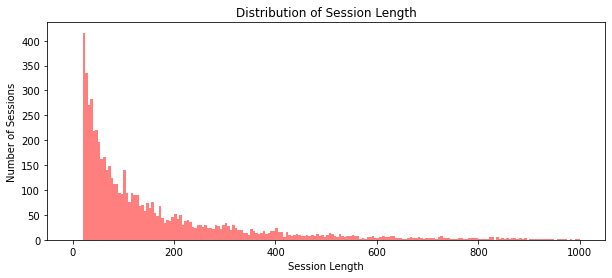

In [9]:
plt.figure(figsize=(10, 4))
plt.hist(session_lengths, bins=200, range=[0,1000], alpha=0.5, color='r')
plt.xlabel('Session Length')
plt.ylabel('Number of Sessions')
plt.title('Distribution of Session Length')
plt.show()

##### 세션 길이 분포
세션 길이 분포를 시각화한 결과, 대부분의 세션 길이가 200 이하임을 볼 수 있으며, 특히 100 이하의 세션 길이를 가진 사용자가 많은 것으로 나타났다.   
극단적으로 많은 영화를 평가한 사용자들도 있으나, 이들은 전체 분포에서 상대적으로 소수이다.

### Session Time

#### 시간 정보 변환 및 분석

In [10]:
data['Datetime'] = pd.to_datetime(data['Time'], unit='s')
data['Year'] = data['Datetime'].dt.year
data['Month'] = data['Datetime'].dt.month
data['Day'] = data['Datetime'].dt.day

##### 시간 범위 분석
변환된 시간 정보를 바탕으로, 데이터셋에 포함된 평가들은 2000년 4월 25일부터 2003년 2월 28일까지의 기간에 이루어진 것으로 나타났다.

In [11]:
time_min = data['Datetime'].min()
time_max = data['Datetime'].max()

time_min, time_max

(Timestamp('2000-04-25 23:05:32'), Timestamp('2003-02-28 17:49:50'))

#### 시간대별 활동 패턴 분석
대체로 저녁 시간대에 사용자 활동이 증가하는 경향을 보이며, 특히 밤 12시를 전후로 활동이 많은 것으로 나타났다.  
이는 사용자들이 일과 후 여가 시간에 영화 평가 활동을 더 많이 하는 경향이 있음을 시사한다.

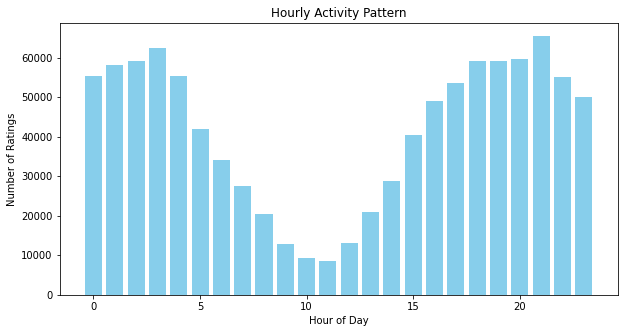

In [12]:
data['Hour'] = data['Datetime'].dt.hour
hourly_activity = data.groupby('Hour').size()

plt.figure(figsize=(10, 5))
plt.bar(hourly_activity.index, hourly_activity.values, color='skyblue')
plt.title('Hourly Activity Pattern')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Ratings')
plt.show()

#### 월별 활동 패턴 분석
월별 활동 패턴을 보면, 특정 월에 사용자 활동이 눈에 띄게 많거나 적은 경향은 보이지 않는다.   
이는 영화 평가 활동이 연중 내내 비교적 균일하게 이루어진다는 것을 의미할 수 있다.   
그러나, 데이터셋에 포함된 시간 범위와 각 해의 사회적, 문화적 이벤트의 영향을 고려해야 할 수도 있다.

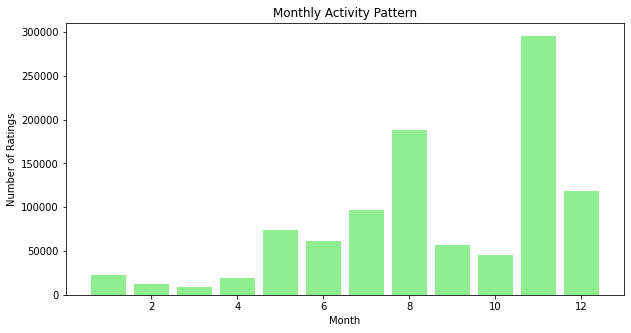

In [13]:
monthly_activity = data.groupby('Month').size()

plt.figure(figsize=(10, 5))
plt.bar(monthly_activity.index, monthly_activity.values, color='lightgreen')
plt.title('Monthly Activity Pattern')
plt.xlabel('Month')
plt.ylabel('Number of Ratings')
plt.show()

#### 년도별 활동 패턴 분석
년도별 활동 패턴을 살펴보면, 활동량이 시간이 지남에 따라 증가하는 경향을 보인다.  
특히 2000년에서 2001년으로 넘어가면서 활동량이 크게 증가했으며, 이후로도 상승 추세를 유지하는 것으로 보인다.   
이는 영화 평가 플랫폼의 사용자 기반이 점점 확대되고 있음을 나타내며, 시간이 지남에 따라 사용자들의 참여도가 높아지고 있음을 시사한다.

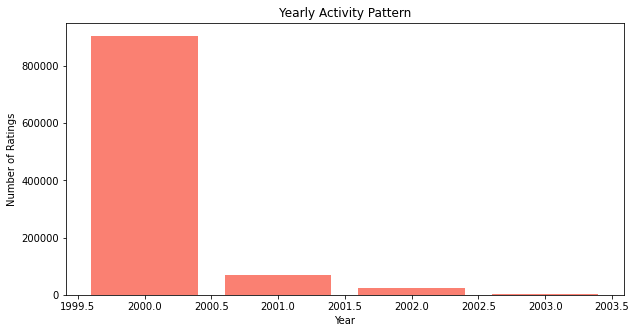

In [14]:
yearly_activity = data.groupby('Year').size()

plt.figure(figsize=(10, 5))
plt.bar(yearly_activity.index, yearly_activity.values, color='salmon')
plt.title('Yearly Activity Pattern')
plt.xlabel('Year')
plt.ylabel('Number of Ratings')
plt.show()

### Data Cleansing
1. 극단적으로 긴 세션 제거
    - 너무 많은 영화를 평가한 사용자는 이상치일 수 있으므로, 이들을 제거한다.
2. 너무 짧은 세션 제거
    - 너무 적은 수의 영화만 평가한 사용자는 유의미한 패턴을 찾기 어려울 수 있으므로, 이들도 제거한다.
3. 낮은 평점의 데이터 제거
    - 사용자가 부여한 평점이 낮은 데이터는 사용자의 선호도를 반영하지 않을 수 있으므로, 일정 평점 이상의 데이터만을 사용한다.


#### 세션 길이 기준 설정

In [15]:
# 상위 99% 세션 길이를 최대 길이로 설정
max_session_length = session_lengths.quantile(0.99)
print(f'Max Session Length : {max_session_length}')

# 하위 1% 세션 길이를 최소 길이로 설정
min_session_length = session_lengths.quantile(0.01)
print(f'Min Session Length : {min_session_length}')

Max Session Length : 906.659999999998
Min Session Length : 20.0


#### 평점 기준 설정

In [16]:
# 3 이상의 평점을 받은 데이터만 사용
min_rating = 3

#### 데이터 클리닝

In [17]:
filtered_data = data[
    (data['UserId'].map(session_lengths) <= max_session_length) &
    (data['UserId'].map(session_lengths) >= min_session_length) &
    (data['Rating'] >= min_rating)
]

#### 클리닝 후 데이터 정보

In [18]:
filtered_data.head()

,UserId,ItemId,Rating,Time,Datetime,Year,Month,Day,Hour
31,1,3186,4,978300019,2000-12-31 22:00:19,2000,12,31,22
22,1,1270,5,978300055,2000-12-31 22:00:55,2000,12,31,22
27,1,1721,4,978300055,2000-12-31 22:00:55,2000,12,31,22
37,1,1022,5,978300055,2000-12-31 22:00:55,2000,12,31,22
24,1,2340,3,978300103,2000-12-31 22:01:43,2000,12,31,22


In [19]:
filtered_info = filtered_data.describe()
filtered_info

,UserId,ItemId,Rating,Time,Year,Month,Day,Hour
count,782556.000000,782556.000000,782556.000000,7.825560e+05,782556.000000,782556.000000,782556.000000,782556.000000
mean,3040.968057,1845.641428,3.969045,9.720476e+08,2000.119948,8.712067,15.391116,11.951459
std,1735.941224,1091.378539,0.761933,1.191658e+07,0.410989,2.711597,8.872629,7.925546
min,1.000000,1.000000,3.000000,9.567039e+08,2000.000000,1.000000,1.000000,0.000000
25%,1547.000000,1029.000000,3.000000,9.652574e+08,2000.000000,7.000000,7.000000,4.000000
50%,3075.000000,1729.000000,4.000000,9.728247e+08,2000.000000,9.000000,17.000000,14.000000
75%,4517.000000,2762.000000,5.000000,9.751613e+08,2000.000000,11.000000,22.000000,19.000000
max,6040.000000,3952.000000,5.000000,1.046455e+09,2003.000000,12.000000,31.000000,23.000000


In [20]:
filtered_session_length_describe = filtered_data.groupby('UserId').size().describe()
filtered_session_length_describe

count    5978.000000
mean      130.905989
std       135.038763
min         1.000000
25%        37.000000
50%        80.000000
75%       172.000000
max       834.000000
dtype: float64

##### 데이터 클리닝 후, 결과
전체 데이터 중에서 평점이 3 이상인 데이터와 사용자별 세션 길이가 하위 1% 이상 및 상위 99% 이하인 데이터만 필터링하여 782,556개의 데이터를 얻었다.  

클리닝 후 데이터의 평균 평점은 약 3.97로, 필터링 전보다 높아졌다.
- 낮은 평점을 받은 데이터를 제외했기 때문이다.  

사용자별 세션 길이는 이제 최소 1개에서 최대 834개의 영화 평가를 포함하며, 평균적으로 약 131개의 영화 평가를 남겼다.
- 필터링 전보다 평균 세션 길이가 줄어들었다.

## Session-Parallel Mini-Batch
Session-Parallel Mini-Batch의 개념에 따라, 학습 속도의 저하가 최소화될 수 있도록 구성한다.  
단, 위 Step 1에서 Session 단위를 어떻게 정의했느냐에 따라서 Session-Parallel Mini-Batch이 굳이 필요하지 않을 수도 있다.

### SessionDataset 
세션 기반 데이터셋을 관리하며, 세션이 시작되는 인덱스(click_offsets)와 세션을 새로 인덱싱한 값(session_idx)을 포함한다.

In [29]:
class SessionDataset:
    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['UserId'].nunique())

    def get_click_offsets(self):
        offsets = np.zeros(self.df['UserId'].nunique() + 1, dtype=int)
        offsets[1:] = self.df.groupby('UserId').size().cumsum()
        return offsets
    
    def __len__(self):
        return len(self.session_idx)

    def get_session(self, idx):
        if idx < len(self.session_idx) - 1:
            start = self.click_offsets[idx]
            end = self.click_offsets[idx + 1]
        else:
            start = self.click_offsets[idx]
            end = len(self.df)
        return self.df.iloc[start:end]

In [30]:
session_dataset = SessionDataset(filtered_data)

# 인스턴스 변수들 살펴보기
print(f"Total sessions: {len(session_dataset.click_offsets) - 1}")
print(f"First 10 session indexes: {session_dataset.click_offsets[:10]}")

Total sessions: 5978
First 10 session indexes: [  0  53 169 215 234 377 446 477 609 707]


### SessionDataLoader
SessionDataLoader 클래스는 SessionDataset 객체를 받아 세션별로 병렬 미니 배치를 생성한다.  
__iter__ 메서드는 모델 입력, 라벨, 그리고 세션이 끝나는 위치를 제너레이터(generator) 형태로 반환한다.

In [28]:
# class SessionDataLoader:
#     def __init__(self, dataset, batch_size):
#         self.dataset = dataset
#         self.batch_size = batch_size

#     def __iter__(self):
#         # 가정: dataset은 (inputs, labels)을 포함하는 pandas DataFrame
#         # inputs: 모델 입력, labels: 정답 라벨
#         start_idx = 0

#         num_batches = len(self.dataset) // self.batch_size
#         for i in range(num_batches):
#             batch = self.dataset.iloc[i*self.batch_size:(i+1)*self.batch_size]
#             inputs = np.array(list(batch['inputs']))  # inputs 컬럼의 데이터를 numpy 배열로 변환
#             labels = np.array(list(batch['labels']))  # labels 컬럼의 데이터를 numpy 배열로 변환
#             yield inputs, labels

In [31]:
class SessionDataLoader:
    """세션 데이터 로더 클래스"""
    
    def __init__(self, dataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        start, end = 0, self.batch_size
        while start < len(self.dataset.session_idx):
            session_mask = np.arange(len(self.dataset.click_offsets))[(self.dataset.click_offsets >= start) & (self.dataset.click_offsets < end)]
            batch_item_ids = []
            batch_next_item_ids = []
            for session_id in session_mask:
                session_start = self.dataset.click_offsets[session_id]
                session_end = self.dataset.click_offsets[session_id + 1] if session_id + 1 < len(self.dataset.click_offsets) else len(self.dataset.df)
                session_item_ids = self.dataset.df['ItemId'].values[session_start:session_end]
                batch_item_ids.extend(session_item_ids[:-1])  # 현재 세션의 아이템들
                batch_next_item_ids.extend(session_item_ids[1:])  # 다음 아이템 (예측 목표)
            
            # numpy 배열로 변환
            np_batch_item_ids = np.array(batch_item_ids, dtype=np.int32)
            np_batch_next_item_ids = np.array(batch_next_item_ids, dtype=np.int32)
            
            yield np_batch_item_ids, np_batch_next_item_ids
            
            start += self.batch_size
            end += self.batch_size

In [32]:
batch_size = 32
data_loader = SessionDataLoader(session_dataset, batch_size)
for idx, batch in enumerate(data_loader):
    print(f"Batch {idx + 1}: Session Indices = {batch[0]}, Locations = {batch[1]}")
    if idx == 1:  # 두 번째 배치에서 반복 중지
        break

Batch 1: Session Indices = [3186 1270 1721 1022 2340 1836 3408 2804 1207 1193  720  260  919  608
 2692 1961 2028 3105  938 1035 1962 2018  150 1028 1097  914 1287 2797
 2762 1246  661 2918  531 3114 2791 2321 1029 1197  594 2398 1545  527
  595 2687  745  588    1 2355 2294  783 1566 1907], Locations = [1270 1721 1022 2340 1836 3408 2804 1207 1193  720  260  919  608 2692
 1961 2028 3105  938 1035 1962 2018  150 1028 1097  914 1287 2797 2762
 1246  661 2918  531 3114 2791 2321 1029 1197  594 2398 1545  527  595
 2687  745  588    1 2355 2294  783 1566 1907   48]
Batch 2: Session Indices = [1198 1210 1217 2717 1293 2943 1225 1193  318 3030 2858 1945 1207  593
 3095 3468 1873  515 2501 3035  110 2067 3147 1247 3105 1357 1196 1957
 1953  920 1834 1084 1962 3471 3654 3735 1259 1954 1784 2728 1103 3451
 3578 2852 3334 3068  265 2312  590 1253 3071 1244 1955 2236 3678  982
 2194 2268 1442 3255  647  235 1096 1124  498 1246 1537 1188 2396 2359
 2321  356 3108 1265 3809  589 2028 2571  457 29

## Modeling

In [33]:
import tensorflow as tf
from tensorflow.keras.layers import Input, GRU, Dense, Dropout, Embedding
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

In [64]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(filtered_data, test_size=0.2, random_state=42)

print(f"Train data shape: {train_data.shape}")
print(f"Test data shape: {test_data.shape}")

Train data shape: (626044, 9)
Test data shape: (156512, 9)


### 모델 구조 정의

In [74]:
def create_model(num_items, embedding_size=50, gru_units=100, dropout_rate=0.1):
    inputs = Input(shape=(None,))
    embedding = Embedding(input_dim=num_items, output_dim=embedding_size)(inputs)
    gru = GRU(gru_units, return_sequences=False)(embedding)
    dropout = Dropout(dropout_rate)(gru)
    outputs = Dense(num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [75]:
# def create_model(num_items, batch_size, embedding_size, dropout_rate, learning_rate):
#     inputs = Input(batch_shape=(batch_size, 1, num_items))
#     gru, _ = GRU(embedding_size, stateful=True, return_state=True)(inputs)
#     dropout = Dropout(dropout_rate)(gru)
#     predictions = Dense(num_items, activation='softmax')(dropout)
    
#     model = Model(inputs=inputs, outputs=predictions)
#     model.compile(optimizer=Adam(learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])
    
#     return model

In [80]:
from tensorflow.keras.layers import Reshape

def create_model(num_items, num_users, embedding_size=50, gru_units=100, dropout_rate=0.1):
    item_input = Input(shape=(1,), name='item_input')
    user_input = Input(shape=(1,), name='user_input')

    item_embedding = Embedding(input_dim=num_items + 1, output_dim=embedding_size, name='item_embedding')(item_input)
    user_embedding = Embedding(input_dim=num_users + 1, output_dim=embedding_size, name='user_embedding')(user_input)

    combined = tf.keras.layers.Concatenate()([user_embedding, item_embedding])
    
    # 여기서는 Flatten 대신 Reshape를 사용하여 입력을 3차원으로 만듭니다.
    combined = Reshape((1, -1))(combined)

    gru = GRU(gru_units, return_sequences=False)(combined)
    dropout = Dropout(dropout_rate)(gru)
    outputs = Dense(num_items, activation='softmax')(dropout)

    model = Model(inputs=[user_input, item_input], outputs=outputs)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model


#### 모델 하이퍼파라미터 설정

In [81]:
# embedding_size = 50                            # 임베딩 벡터의 차원
# dropout_rate = 0.1                             # 드롭아웃 비율
# learning_rate = 0.001                          # 학습률
num_users = data['UserId'].nunique()
num_items = data['ItemId'].nunique()

#### 모델 생성


In [82]:
model = create_model(num_items, num_users)

### 모델 학습

In [83]:
# def train_model(model, train_loader, epochs):
#     for epoch in range(epochs):
#         for inputs, labels in train_loader:
#             # 여기서 inputs와 labels는 실제 사용하는 데이터셋에 맞게 조정해야 한다.
#             loss, accuracy = model.train_on_batch(inputs, labels)
#         print(f'Epoch {epoch+1}/{epochs}, Loss: {loss}, Accuracy: {accuracy}')

In [84]:
epochs = 10
for epoch in range(epochs):  # 총 에포크 수
    for users, items, ratings in DataGenerator(train_data):
        # NumPy 배열로 변환
        users_np = np.array(users, dtype=np.int32)
        items_np = np.array(items, dtype=np.int32)
        ratings_np = np.array(ratings, dtype=np.float32)
        
        # TensorFlow 텐서로 변환
        users_tf = tf.convert_to_tensor(users_np, dtype=tf.int32)
        items_tf = tf.convert_to_tensor(items_np, dtype=tf.int32)
        ratings_tf = tf.convert_to_tensor(ratings_np, dtype=tf.float32)
        
        # 모델 학습
        loss = model.train_on_batch([users_tf, items_tf], ratings_tf)
    print(f"Epoch {epoch+1}, Loss: {loss}")

Epoch 1, Loss: [0.8723084330558777, 0.5887096524238586]
Epoch 2, Loss: [0.9682059288024902, 0.5080645084381104]
Epoch 3, Loss: [0.9568608403205872, 0.5483871102333069]
Epoch 4, Loss: [0.9541283845901489, 0.4838709533214569]
Epoch 5, Loss: [0.8985830545425415, 0.5725806355476379]
Epoch 6, Loss: [0.8796716928482056, 0.6048387289047241]
Epoch 7, Loss: [0.9224159717559814, 0.5080645084381104]
Epoch 8, Loss: [0.876793384552002, 0.6209677457809448]
Epoch 9, Loss: [0.920186460018158, 0.5564516186714172]
Epoch 10, Loss: [0.8171398639678955, 0.5806451439857483]


### 모델 테스트
미리 구성한 테스트셋을 바탕으로 Recall, MRR 을 확인해 본다.

In [85]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0


def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

In [86]:
# def test_model(model, test_loader, k):
#     recall_k_scores = []
#     mrr_k_scores = []

#     # 테스트 데이터셋을 순회합니다.
#     for inputs, labels in test_loader:
#         # 모델 예측
#         predictions = model.predict(inputs)  # model.predict의 출력은 배치 내 각 아이템에 대한 예측 확률입니다.
        
#         # 각 배치에 대한 Recall@K와 MRR@K를 계산합니다.
#         for label, prediction in zip(labels, predictions):
#             # 예측된 확률이 높은 상위 K개 아이템의 인덱스를 가져옵니다.
#             top_k_indices = prediction.argsort()[-k:][::-1]
#             # 실제 아이템 인덱스
#             truth_index = np.argwhere(label == 1).flatten()[0]  # 실제 라벨이 1인 아이템의 인덱스
            
#             recall_score = recall_k(top_k_indices, truth_index, k)
#             mrr_score = mrr_k(top_k_indices, truth_index, k)
            
#             recall_k_scores.append(recall_score)
#             mrr_k_scores.append(mrr_score)
    
#     # 평균 Recall@K와 MRR@K를 계산합니다.
#     avg_recall_k = np.mean(recall_k_scores)
#     avg_mrr_k = np.mean(mrr_k_scores)
    
#     print(f'Average Recall@{k}: {avg_recall_k:.4f}')
#     print(f'Average MRR@{k}: {avg_mrr_k:.4f}')

In [95]:
def evaluate_model(model, user_ids, item_ids, labels, k=10):
    recall_k_scores = []
    mrr_k_scores = []
    
    # 모델 예측
    predictions = model.predict([user_ids, item_ids])
    
    # 각 사용자에 대한 Recall@K와 MRR@K를 계산합니다.
    for user_id, item_id, label, prediction in zip(user_ids, item_ids, labels, predictions):
        top_k_indices = np.argsort(prediction)[-k:][::-1]  # 상위 K개 아이템
        recall_score = recall_k(top_k_indices, item_id, k)
        mrr_score = mrr_k(top_k_indices, item_id, k)
        recall_k_scores.append(recall_score)
        mrr_k_scores.append(mrr_score)
    
    # 평균 Recall@K와 MRR@K를 계산합니다.
    avg_recall_k = np.mean(recall_k_scores)
    avg_mrr_k = np.mean(mrr_k_scores)
    
    print(f'Average Recall@{k}: {avg_recall_k:.4f}')
    print(f'Average MRR@{k}: {avg_mrr_k:.4f}')

In [96]:
# 테스트 데이터셋에서 사용자 ID와 아이템 ID를 추출
test_user_ids = test_data['UserId'].values
test_item_ids = test_data['ItemId'].values
test_labels = test_data['ItemId'].values

In [97]:
# 모델 평가 실행
k = 10  # 상위 k개 아이템을 고려한 평가
evaluate_model(model, test_user_ids, test_item_ids, test_labels, k)

Average Recall@10: 0.0028
Average MRR@10: 0.0009
